In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Create an engine to connect to your DuckDB database
engine = create_engine("duckdb:///C:/Users/hugoa/DSAI_MAIN/DSAI_project/olist.db")


In [3]:
# Load fact_sales table into a pandas DataFrame
df_sales = pd.read_sql("SELECT * FROM fact_sales", engine)
print(df_sales.head())


                           order_id  order_item_id  customer_key  product_key  \
0  e481f51cbdc54678b7cc49136f2d6af7              1         61761        17418   
1  47770eb9100c2d0c44946d9cf07ec65d              1         25514        21799   
2  949d5b44dbf5de918fe9c16f97b45f8a              1         96584        26906   
3  ad21c59c0840e6cb83a9ceb5573f8159              1         53774        13061   
4  a4591c265e18cb1dcee52889e2d8acc3              1         31118          761   

   order_date_key order_purchase_timestamp   order_approved_at  \
0        20171002      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        20180808      2018-08-08 08:38:49 2018-08-08 08:55:23   
2        20171118      2017-11-18 19:28:06 2017-11-18 19:45:59   
3        20180213      2018-02-13 21:18:39 2018-02-13 22:20:29   
4        20170709      2017-07-09 21:57:05 2017-07-09 22:10:13   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 

In [4]:
print(df_sales.info())
print(df_sales.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   customer_key                   112650 non-null  int64         
 3   product_key                    112650 non-null  int64         
 4   order_date_key                 112650 non-null  int64         
 5   order_purchase_timestamp       112650 non-null  datetime64[ns]
 6   order_approved_at              112635 non-null  datetime64[ns]
 7   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 8   order_delivered_customer_date  110196 non-null  datetime64[ns]
 9   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 10  price                          112650 non-null  float64       
 11  

       month  total_sale_amount
0 2016-09-01             354.75
1 2016-10-01           56808.84
2 2016-12-01              19.62
3 2017-01-01          137188.49
4 2017-02-01          286280.62


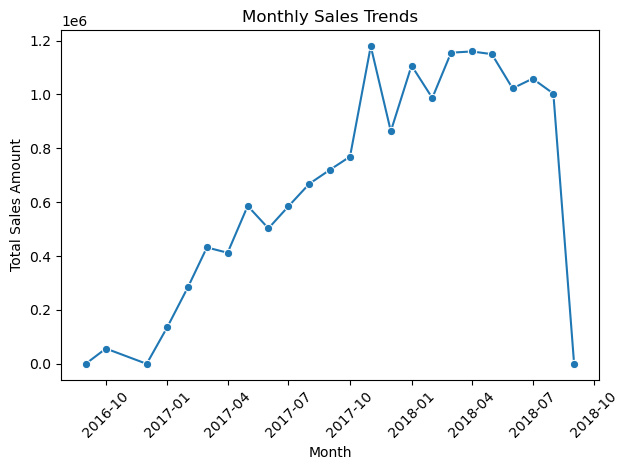

In [5]:
# Calculate Key Metrics

df_sales['order_purchase_timestamp'] = pd.to_datetime(df_sales['order_purchase_timestamp'])
df_sales['month'] = df_sales['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()


monthly_sales = df_sales.groupby('month')['total_sale_amount'].sum().reset_index()
print(monthly_sales.head())


sns.lineplot(data=monthly_sales, x='month', y='total_sale_amount', marker='o')
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Sales Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Index(['product_key', 'product_id', 'product_category', 'weight', 'length',
       'height', 'width'],
      dtype='object')
Index(['order_id', 'order_item_id', 'customer_key', 'product_key',
       'order_date_key', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'price', 'freight_value',
       'total_sale_amount', 'payment_type', 'total_installments',
       'total_payment_value', 'month', 'product_id', 'product_category',
       'weight', 'length', 'height', 'width'],
      dtype='object')
          product_category  total_sale_amount
11            beleza_saude         1441248.07
66      relogios_presentes         1305541.61
13         cama_mesa_banho         1241681.72
32           esporte_lazer         1156656.48
44  informatica_acessorios         1059272.40
54        moveis_decoracao          902511.79
72   utilidades_domesticas          778397.77
26              cool

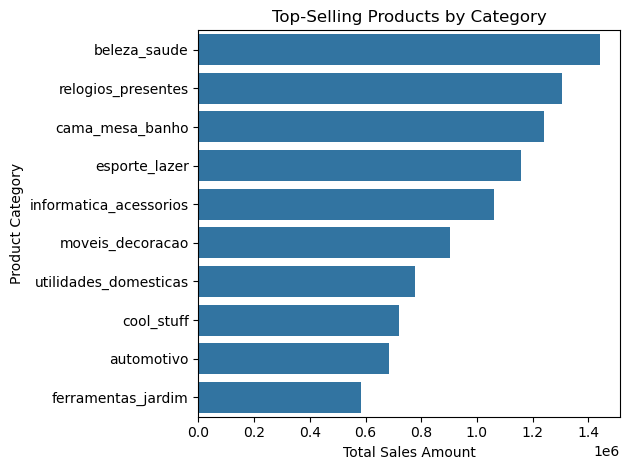

In [6]:
# Top-Selling Products
df_products = pd.read_sql("SELECT * FROM dim_product", engine)
print(df_products.columns)

df_sales_products = df_sales.merge(df_products, on='product_key', how='left')
print(df_sales_products.columns)

top_products = (
    df_sales_products
    .groupby('product_category')['total_sale_amount']
    .sum()
    .reset_index()
    .sort_values(by='total_sale_amount', ascending=False)
    .head(10)
)
print(top_products)

sns.barplot(data=top_products, x='total_sale_amount', y='product_category')
plt.title("Top-Selling Products by Category")
plt.xlabel("Total Sales Amount")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

   customer_key  total_sale_amount
0             1             114.74
1             2              67.41
2             3             195.42
3             4             179.35
4             5             107.01
   customer_key  total_sale_amount segment
0             1             114.74  Medium
1             2              67.41     Low
2             3             195.42  Medium
3             4             179.35  Medium
4             5             107.01  Medium


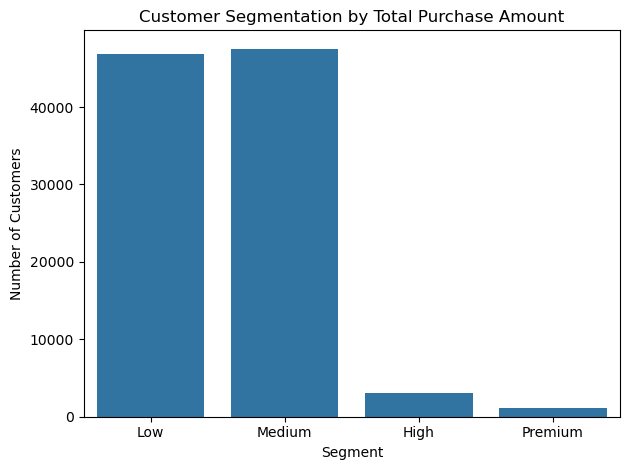

In [7]:
# Customer Segmentation by Purchase Behavior
customer_sales = df_sales.groupby('customer_key')['total_sale_amount'].sum().reset_index()
print(customer_sales.head())

bins = [0, 100, 500, 1000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Premium']
customer_sales['segment'] = pd.cut(customer_sales['total_sale_amount'], bins=bins, labels=labels)
print(customer_sales.head())

sns.countplot(data=customer_sales, x='segment', order=labels)
plt.title("Customer Segmentation by Total Purchase Amount")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


C:\Users\hugoa\AppData\Local\Temp\ipykernel_18932\2552751714.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


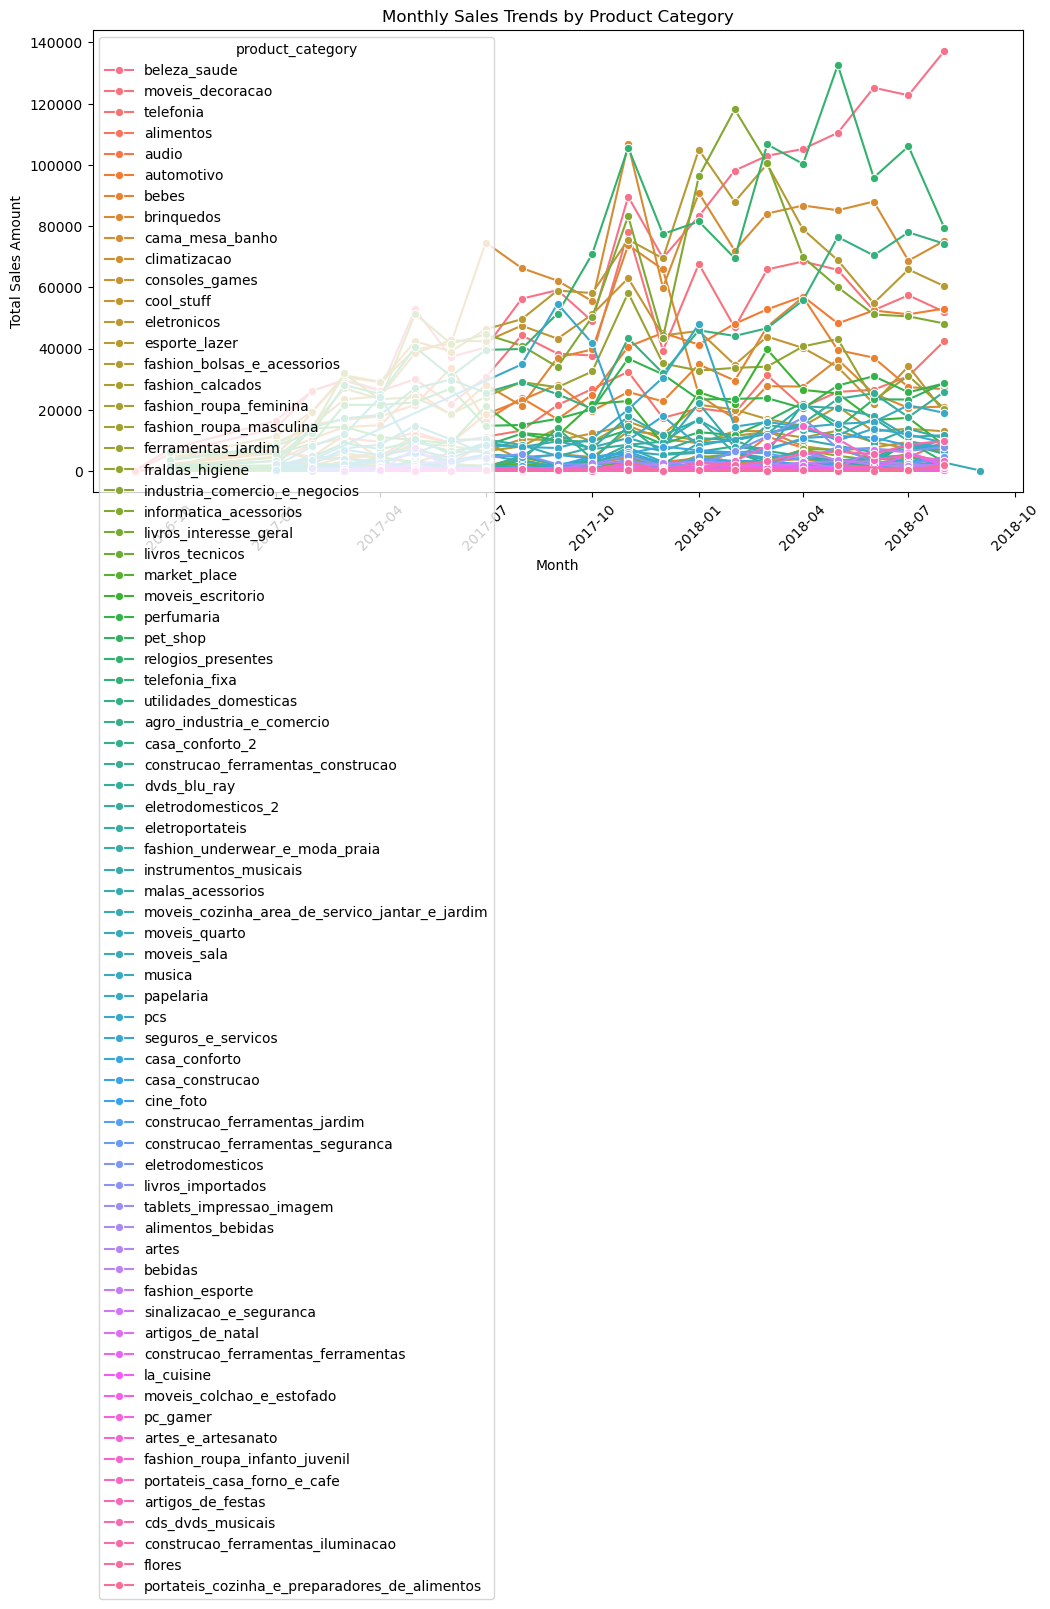

In [8]:
# Monthly Sales Trends by Product Category

# Load fact_sales and dim_product data
df_sales = pd.read_sql("SELECT * FROM fact_sales", engine)
df_products = pd.read_sql("SELECT * FROM dim_product", engine)

# Ensure the purchase timestamp is datetime and extract the month
df_sales['order_purchase_timestamp'] = pd.to_datetime(df_sales['order_purchase_timestamp'])
df_sales['month'] = df_sales['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# Merge with product dimension to get the product category (adjust the column name as needed)
df_sales_products = df_sales.merge(df_products, on='product_key', how='left')

# Aggregate total sales by month and product category
monthly_category_sales = (
    df_sales_products
    .groupby(['month', 'product_category'])['total_sale_amount']
    .sum()
    .reset_index()
)

# Plot the trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_category_sales, x='month', y='total_sale_amount', hue='product_category', marker='o')
plt.title("Monthly Sales Trends by Product Category")
plt.xlabel("Month")
plt.ylabel("Total Sales Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\hugoa\AppData\Local\Temp\ipykernel_18932\1502310466.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_freight_by_state, x='state', y='freight_value', palette="coolwarm")


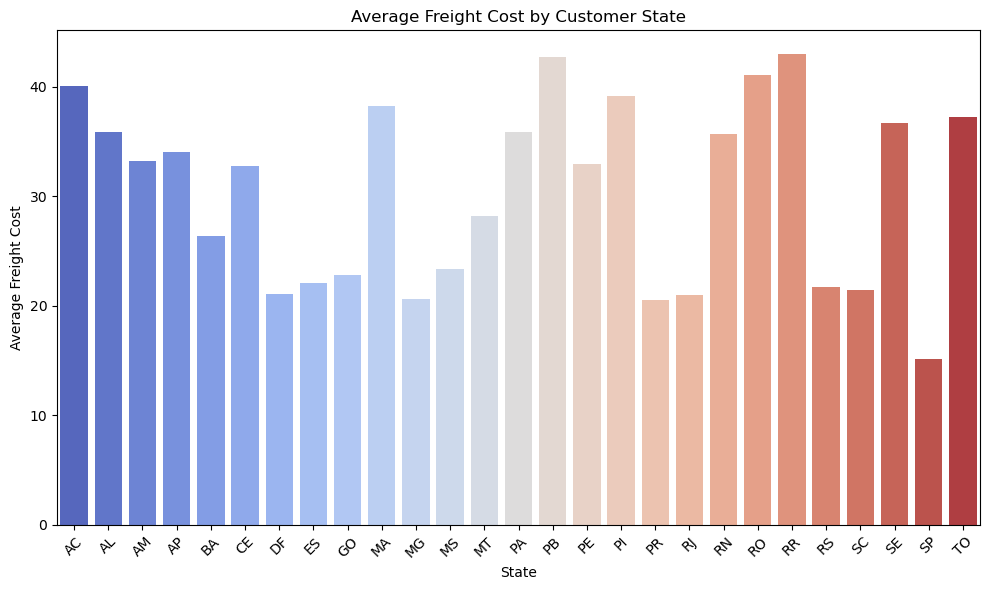

In [9]:
# Average Freight Cost by Customer State
# Load fact_sales and dim_customer data
df_sales = pd.read_sql("SELECT * FROM fact_sales", engine)
df_customers = pd.read_sql("SELECT * FROM dim_customer", engine)

# Merge sales with customer data on the surrogate key (assumed to be 'customer_key')
df_sales_customers = df_sales.merge(df_customers, on='customer_key', how='left')

# Calculate the average freight cost for each state
avg_freight_by_state = (
    df_sales_customers
    .groupby('state')['freight_value']
    .mean()
    .reset_index()
)

# Plot the average freight cost
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_freight_by_state, x='state', y='freight_value', palette="coolwarm")
plt.title("Average Freight Cost by Customer State")
plt.xlabel("State")
plt.ylabel("Average Freight Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


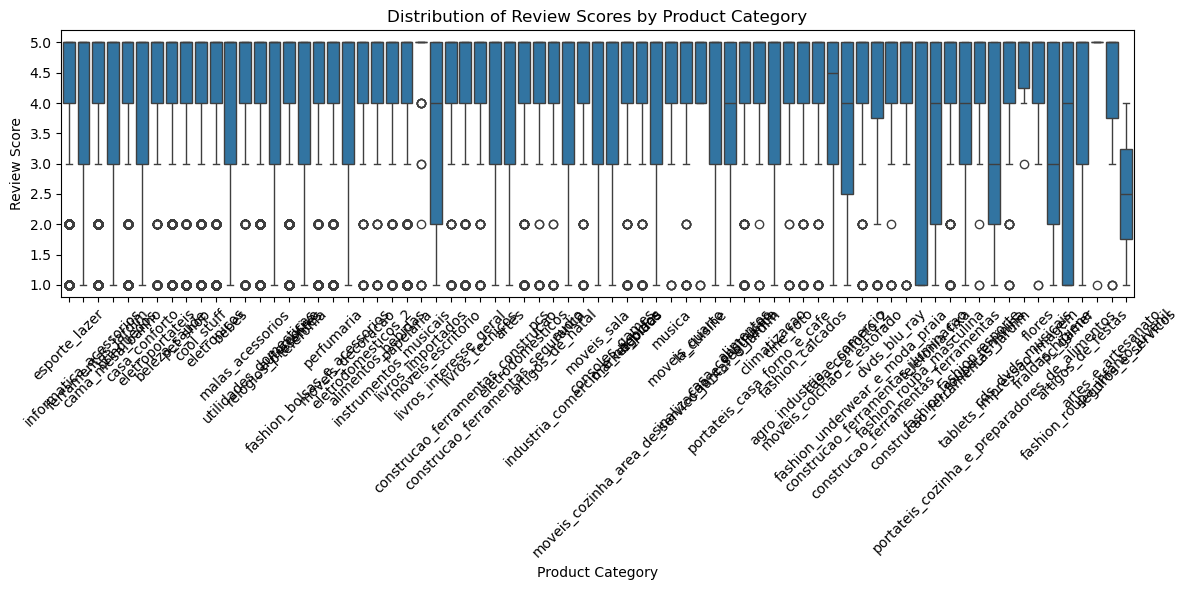

In [10]:
# Distribution of Review Scores by Product Category
# Load fact_reviews, fact_sales (to get order-product mapping), and dim_product data
df_reviews = pd.read_sql("SELECT * FROM fact_reviews", engine)
df_sales = pd.read_sql("SELECT order_id, product_key FROM fact_sales", engine)
df_products = pd.read_sql("SELECT * FROM dim_product", engine)

# Merge reviews with sales on order_id, then join with product dimension for product_category
df_reviews_sales = df_reviews.merge(df_sales, on='order_id', how='left')
df_reviews_sales = df_reviews_sales.merge(df_products, on='product_key', how='left')

# Plot a boxplot of review scores by product category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_reviews_sales, x='product_category', y='review_score')
plt.title("Distribution of Review Scores by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Review Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("duckdb:///C:/Users/hugoa/DSAI_MAIN/DSAI_project/olist.db")
tables = pd.read_sql("SHOW TABLES;", engine)
print(tables)


                            name
0                      customers
1                   dim_customer
2                       dim_date
3                    dim_product
4   fact_customer_lifetime_value
5                   fact_reviews
6                     fact_sales
7                    geolocation
8                    order_items
9                 order_payments
10                 order_reviews
11                        orders
12                      products
13                       sellers
14                 stg_customers
15               stg_order_items
16            stg_order_payments
17             stg_order_reviews
18                    stg_orders
19                  stg_products


C:\Users\hugoa\AppData\Local\Temp\ipykernel_18932\1222743499.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_order_value_by_payment, x='payment_type', y='total_sale_amount', palette="viridis")


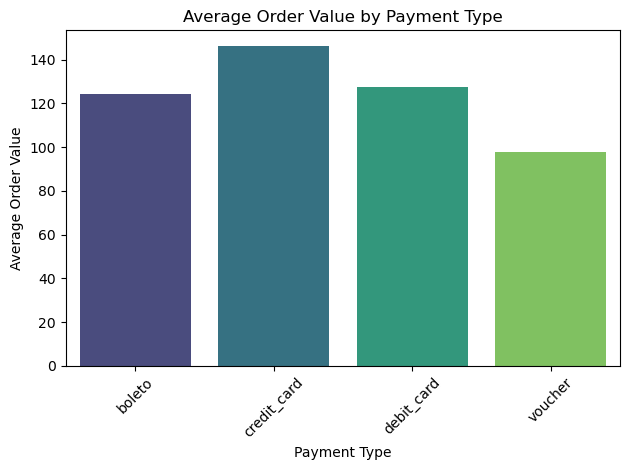

In [12]:
# Payment Type vs. Average Order Value
# Load fact_sales and fact_payments (adjust table name/columns as needed)
# Assuming fact_sales has a 'payment_type' column
df_sales = pd.read_sql("SELECT order_id, total_sale_amount, payment_type FROM fact_sales", engine)

avg_order_value_by_payment = (
    df_sales.groupby('payment_type')['total_sale_amount']
    .mean()
    .reset_index()
)

sns.barplot(data=avg_order_value_by_payment, x='payment_type', y='total_sale_amount', palette="viridis")
plt.title("Average Order Value by Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Average Order Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



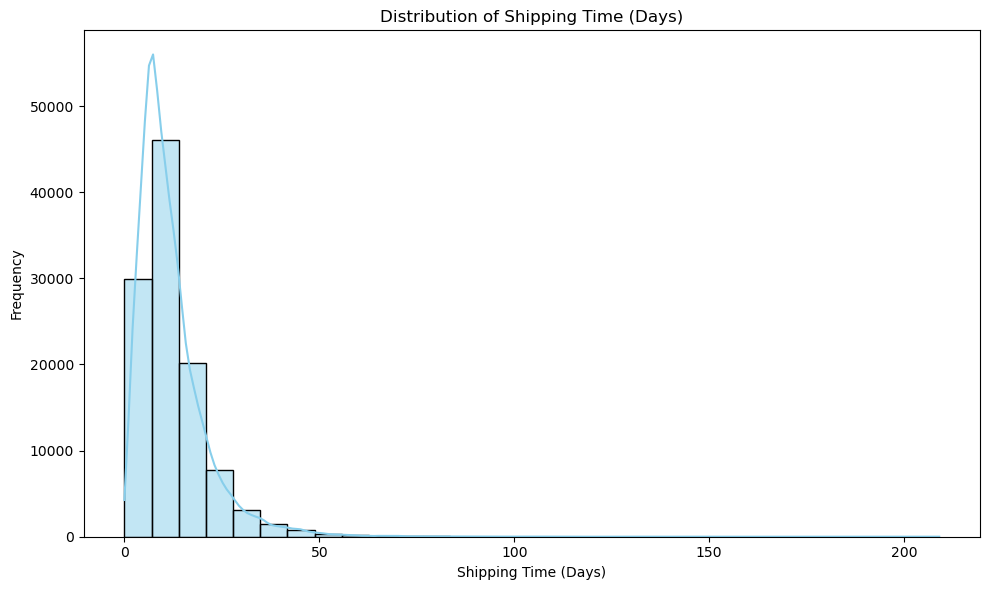

In [13]:
# Shipping Time Analysis
# Load fact_sales data
df_sales = pd.read_sql("SELECT * FROM fact_sales", engine)

# Convert timestamps to datetime
df_sales['order_purchase_timestamp'] = pd.to_datetime(df_sales['order_purchase_timestamp'])
df_sales['order_delivered_customer_date'] = pd.to_datetime(df_sales['order_delivered_customer_date'])

# Calculate shipping time in days
df_sales['shipping_time_days'] = (df_sales['order_delivered_customer_date'] - df_sales['order_purchase_timestamp']).dt.days

# Plot a histogram of shipping times
plt.figure(figsize=(10, 6))
sns.histplot(df_sales['shipping_time_days'].dropna(), bins=30, kde=True, color='skyblue')
plt.title("Distribution of Shipping Time (Days)")
plt.xlabel("Shipping Time (Days)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
